In [18]:
import utility as ut
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
import math

In [2]:
# File paths
DIRECTORY = "data/"
GANTRY_CRANE_PARAMETERS_JSON_PATH = "gantry_crane_parameters.json"
RESULTS_PATH = "FPA_results/"

In [3]:
# Load data
datasets = ut.load_excel_data(DIRECTORY)

In [4]:
DURATION = 15  # duration in seconds
DT = 0.0001  # time increment in seconds
# Create a time array
time_array = np.arange(0, DURATION + DT, DT)
NUM_STEPS = len(time_array)

In [5]:
interpolated_datasets = []
for i in range(len(datasets)):
    new_trolley_position = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position"]
    )
    new_cable_length = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length"]
    )
    new_sway_angle = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["sway_angle"]
    )
    new_trolley_speed = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_position_first_derivative"]
    )
    new_cable_speed = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["cable_length_first_derivative"]
    )
    new_trolley_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_trolley_motor"]
    )
    new_hoist_motor_pwm = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["pwm_hoist_motor"]
    )
    new_trolley_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["trolley_motor_voltage"]
    )
    new_hoist_motor_voltage = np.interp(
        time_array, datasets[i]["timestamp"], datasets[i]["hoist_motor_voltage"]
    )

    interpolated_df = {
        "time": time_array,
        "trolley_position": new_trolley_position,
        "cable_length": new_cable_length,
        "sway_angle": new_sway_angle,
        "trolley_speed": new_trolley_speed,
        "cable_speed": new_cable_speed,
        "trolley_motor_pwm": new_trolley_motor_pwm,
        "hoist_motor_pwm": new_hoist_motor_pwm,
        "trolley_motor_voltage": new_trolley_motor_voltage,
        "hoist_motor_voltage": new_hoist_motor_voltage,
    }

    interpolated_datasets.append(interpolated_df)

print(len(interpolated_datasets))


39


In [6]:
max_sway_angle = 0
for i in range(len(interpolated_datasets)):
    max_sway_angle = max(
        max_sway_angle, max(abs(interpolated_datasets[i]["sway_angle"]))
    )

# Sort the interpolated_datasets by average trolley motor PWM from lowest to highest and then by average hoist motor PWM from lowest to highest
interpolated_datasets.sort(key=lambda x: np.mean(x["trolley_motor_pwm"]))
interpolated_datasets.sort(key=lambda x: np.mean(x["hoist_motor_pwm"]))

for key in interpolated_datasets[0]:
    print(key)

time
trolley_position
cable_length
sway_angle
trolley_speed
cable_speed
trolley_motor_pwm
hoist_motor_pwm
trolley_motor_voltage
hoist_motor_voltage


In [7]:
USE_BEST_DATASET = True
best_dataset = []
if USE_BEST_DATASET:
    for index in range(len(interpolated_datasets)):
        if (index >= 9 and index <= 20) or (index >= 30):
            continue
        best_dataset.append(interpolated_datasets[index])
    
    interpolated_datasets = best_dataset

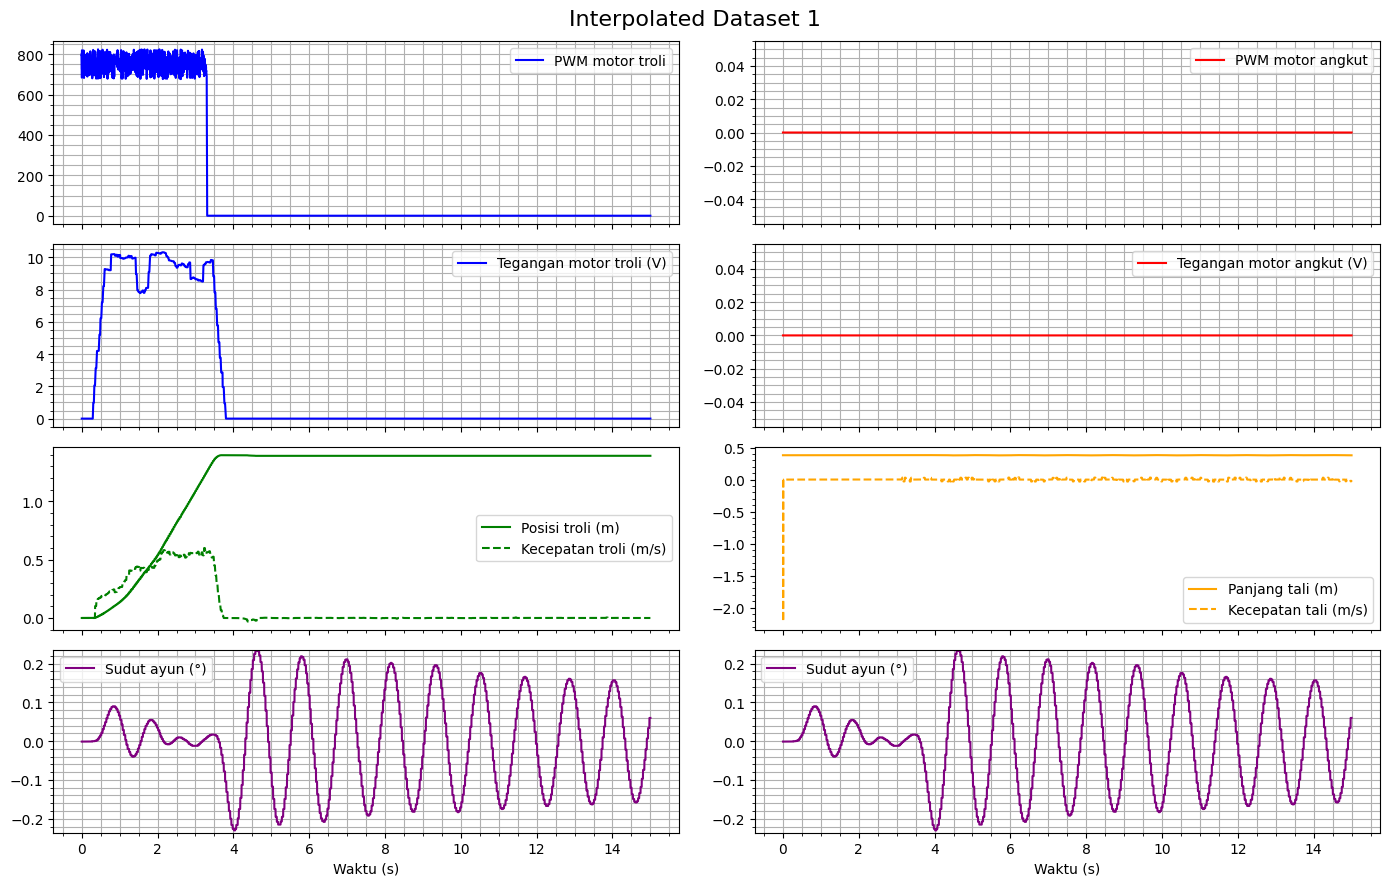

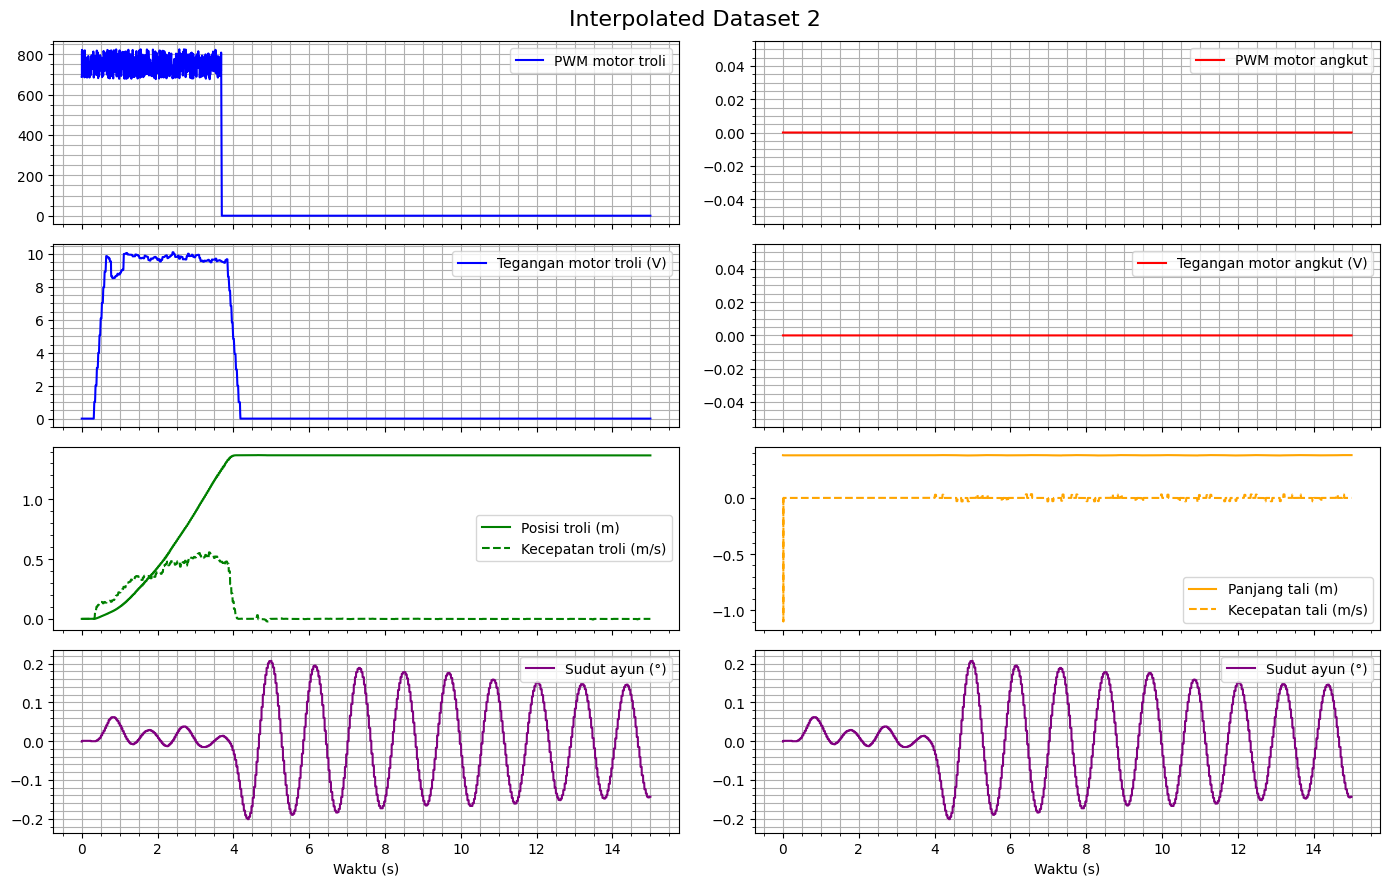

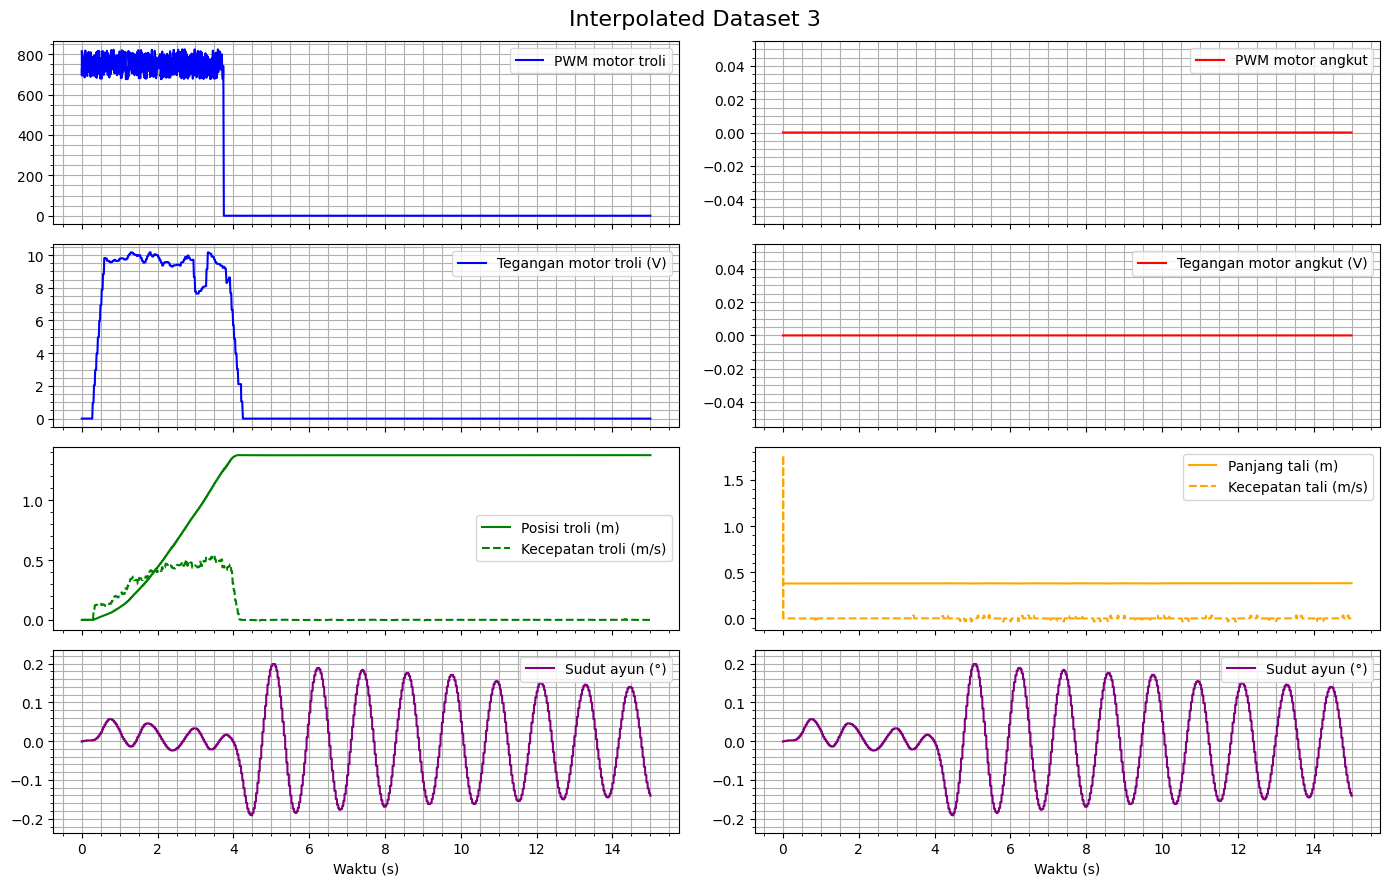

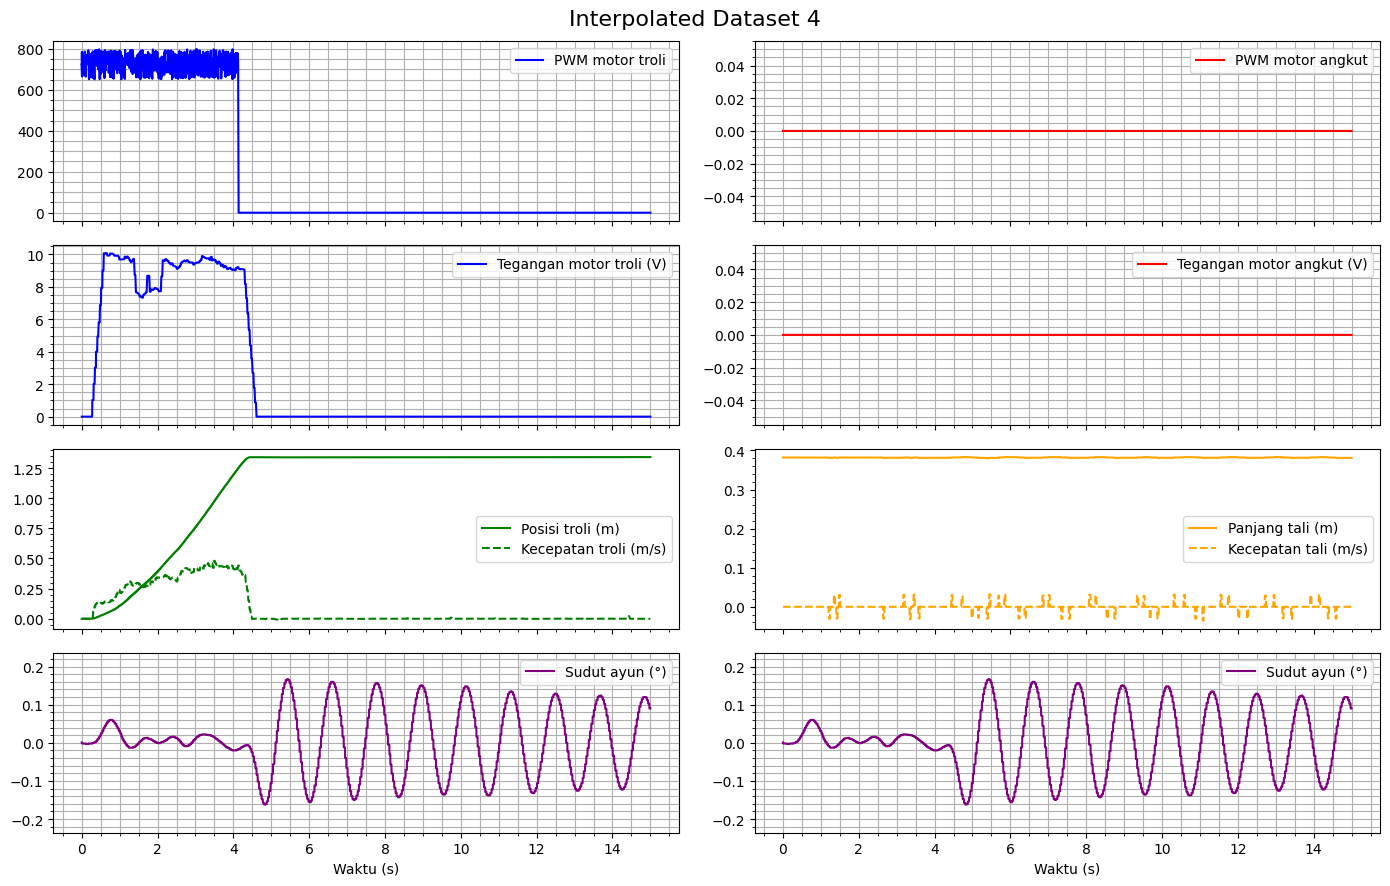

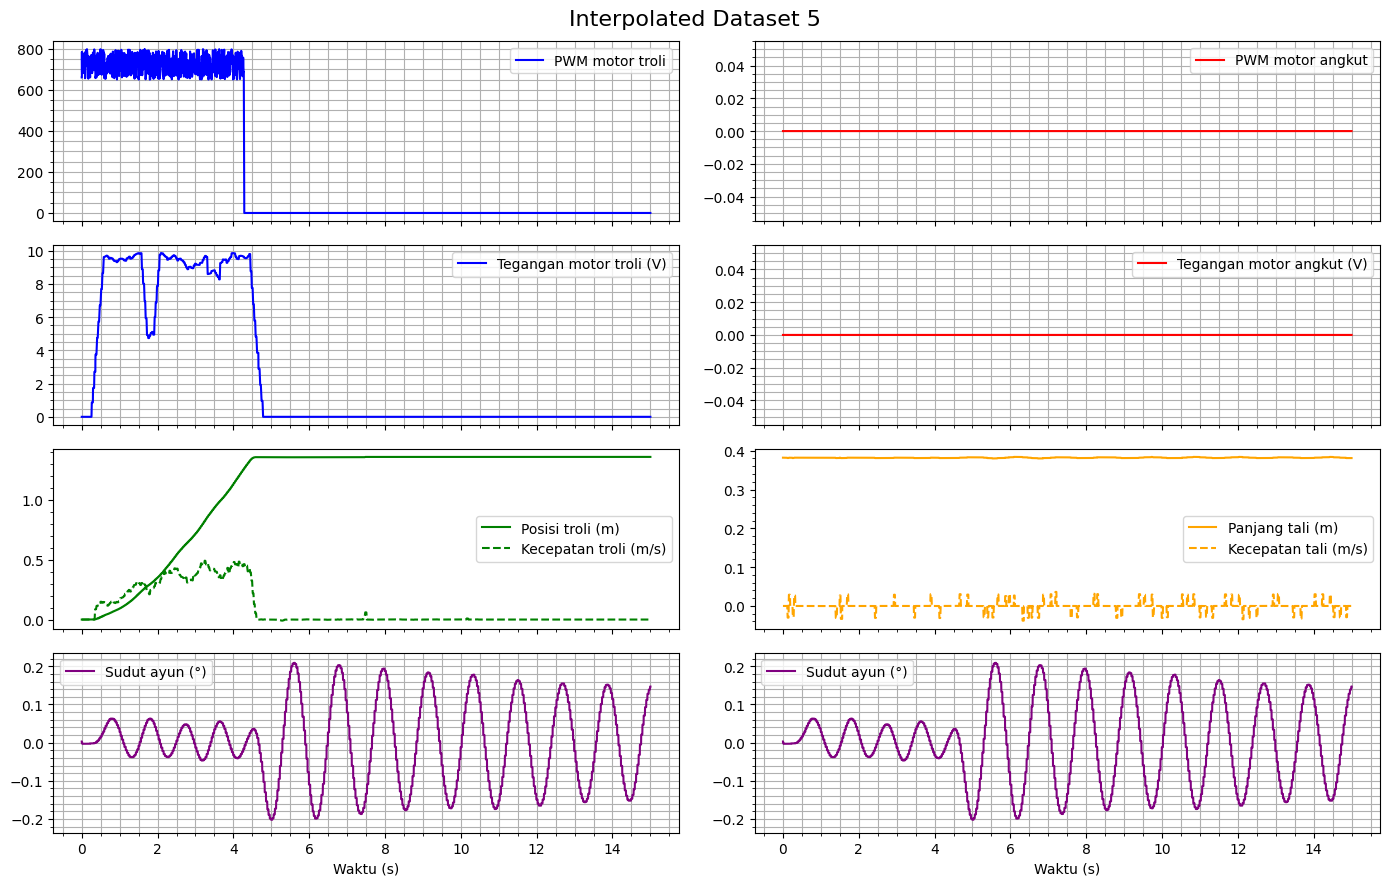

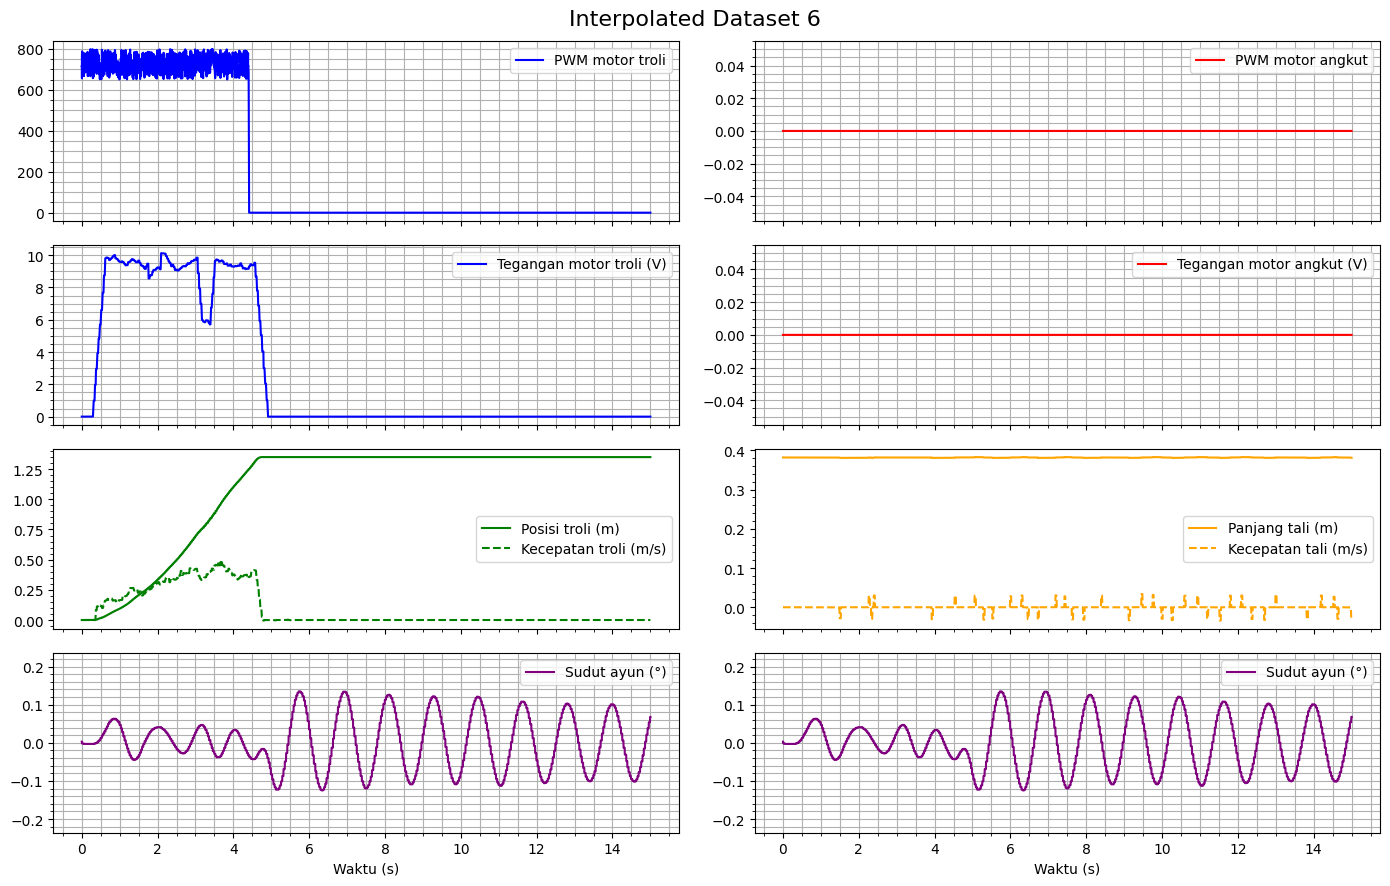

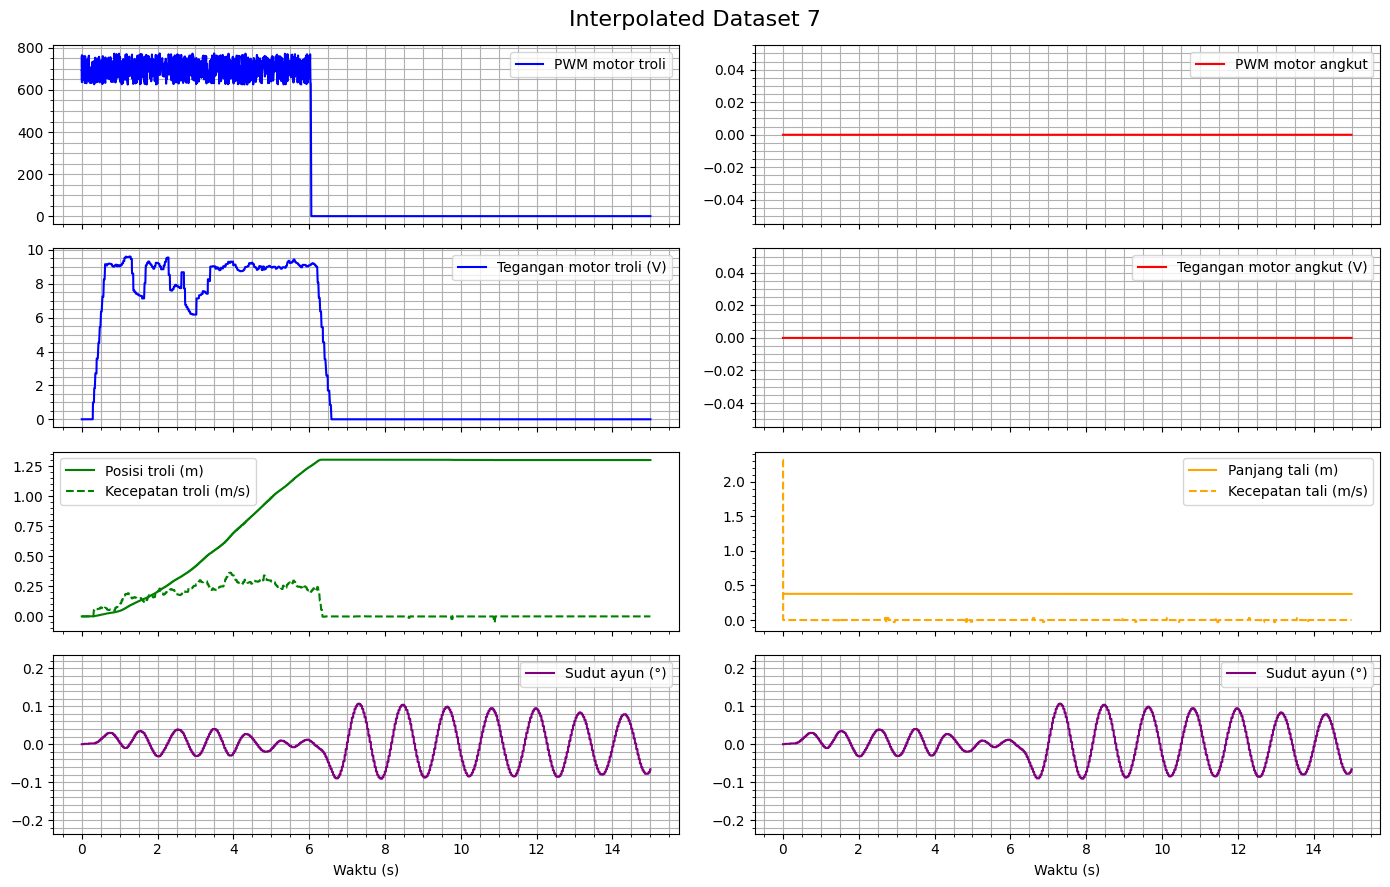

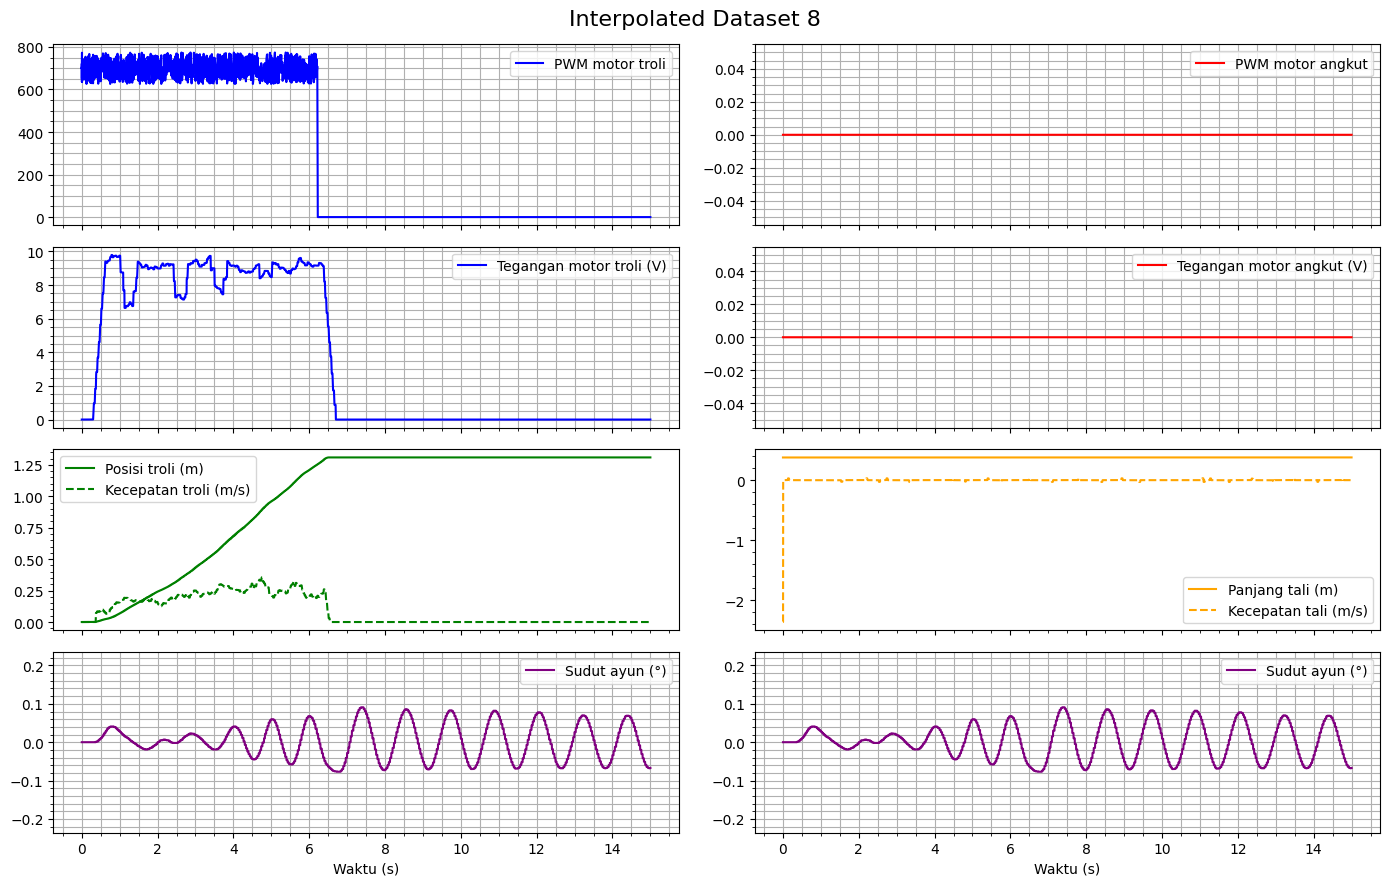

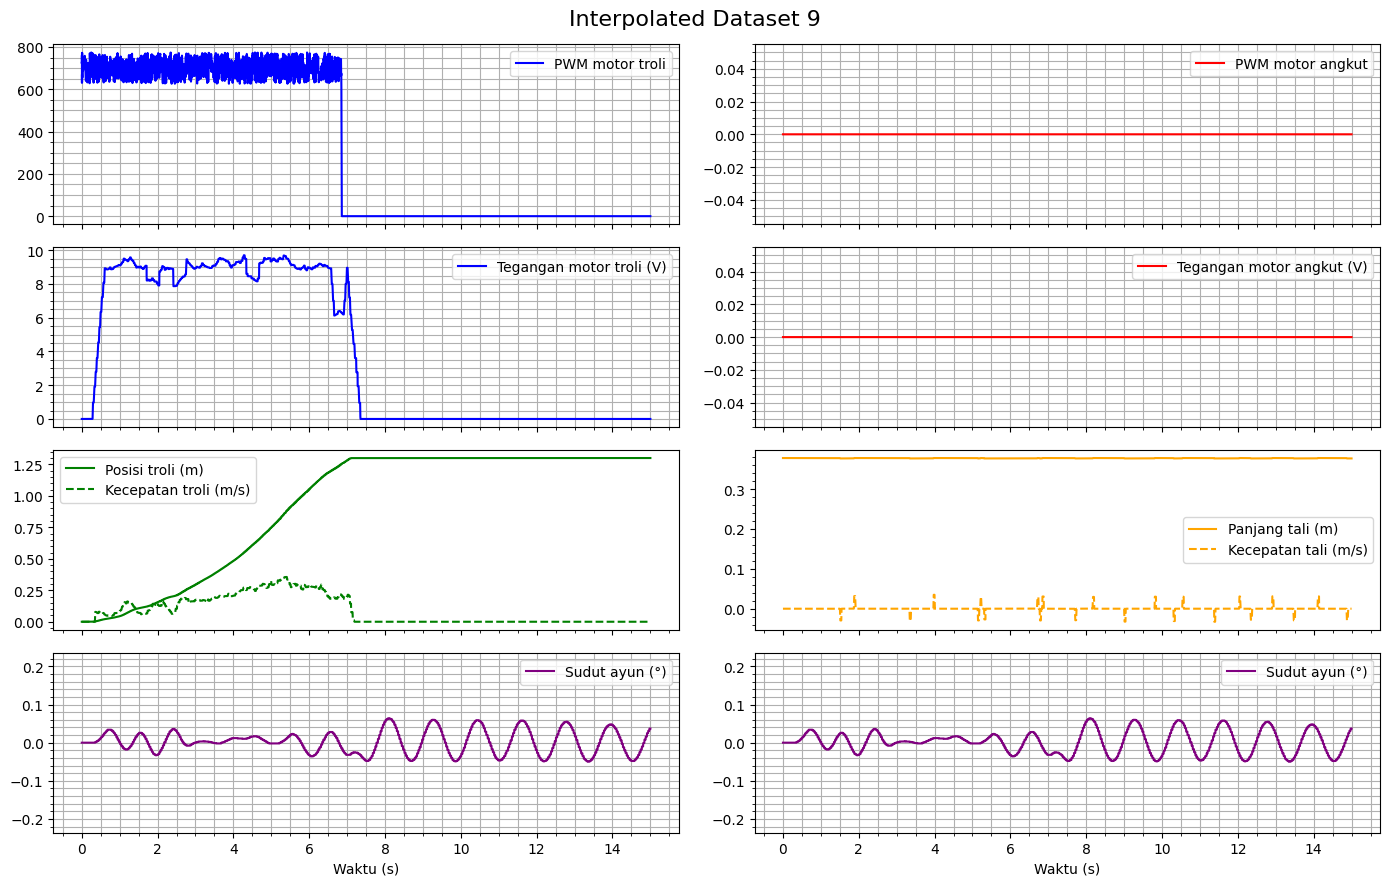

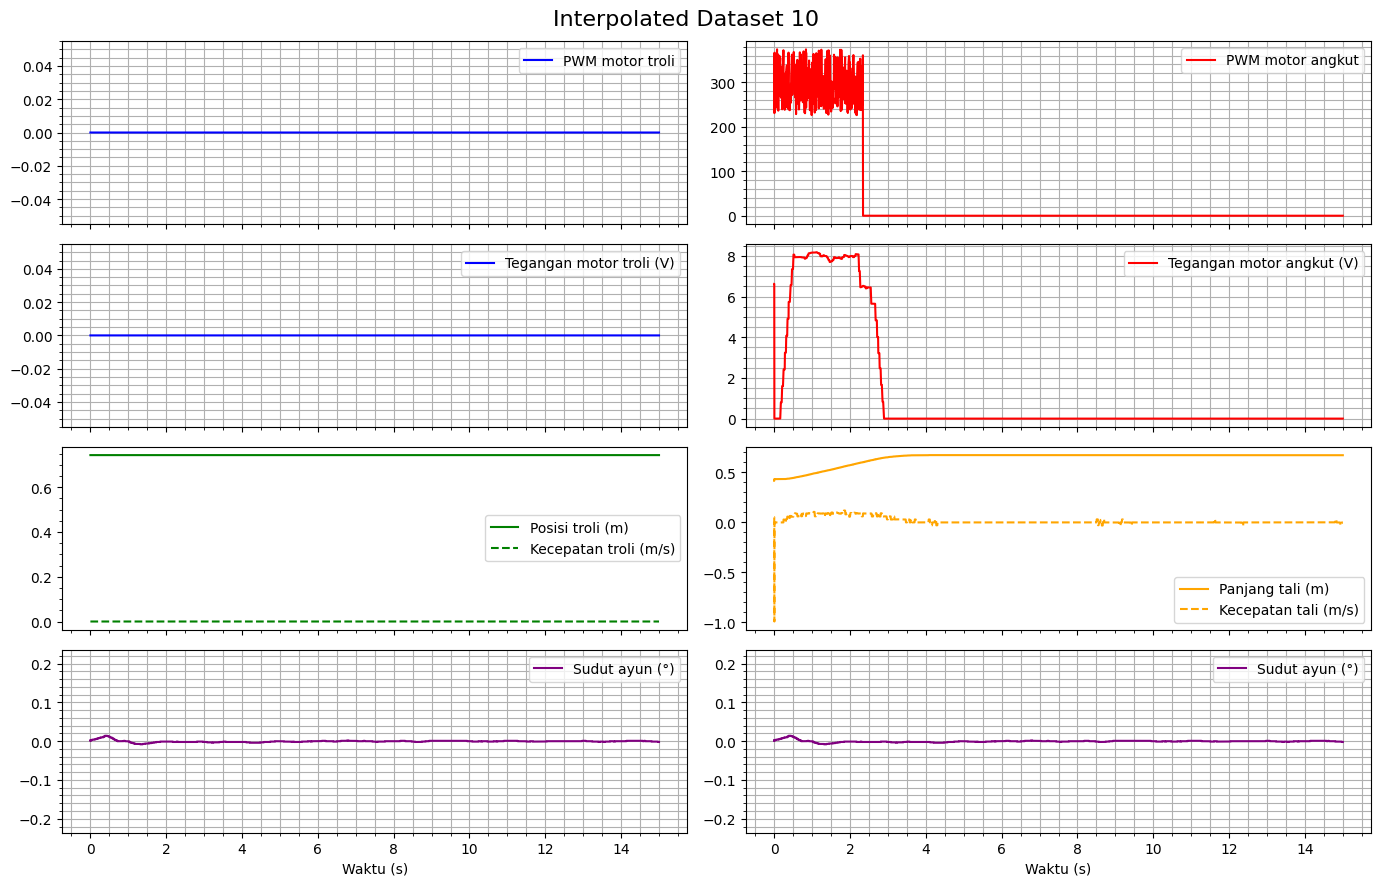

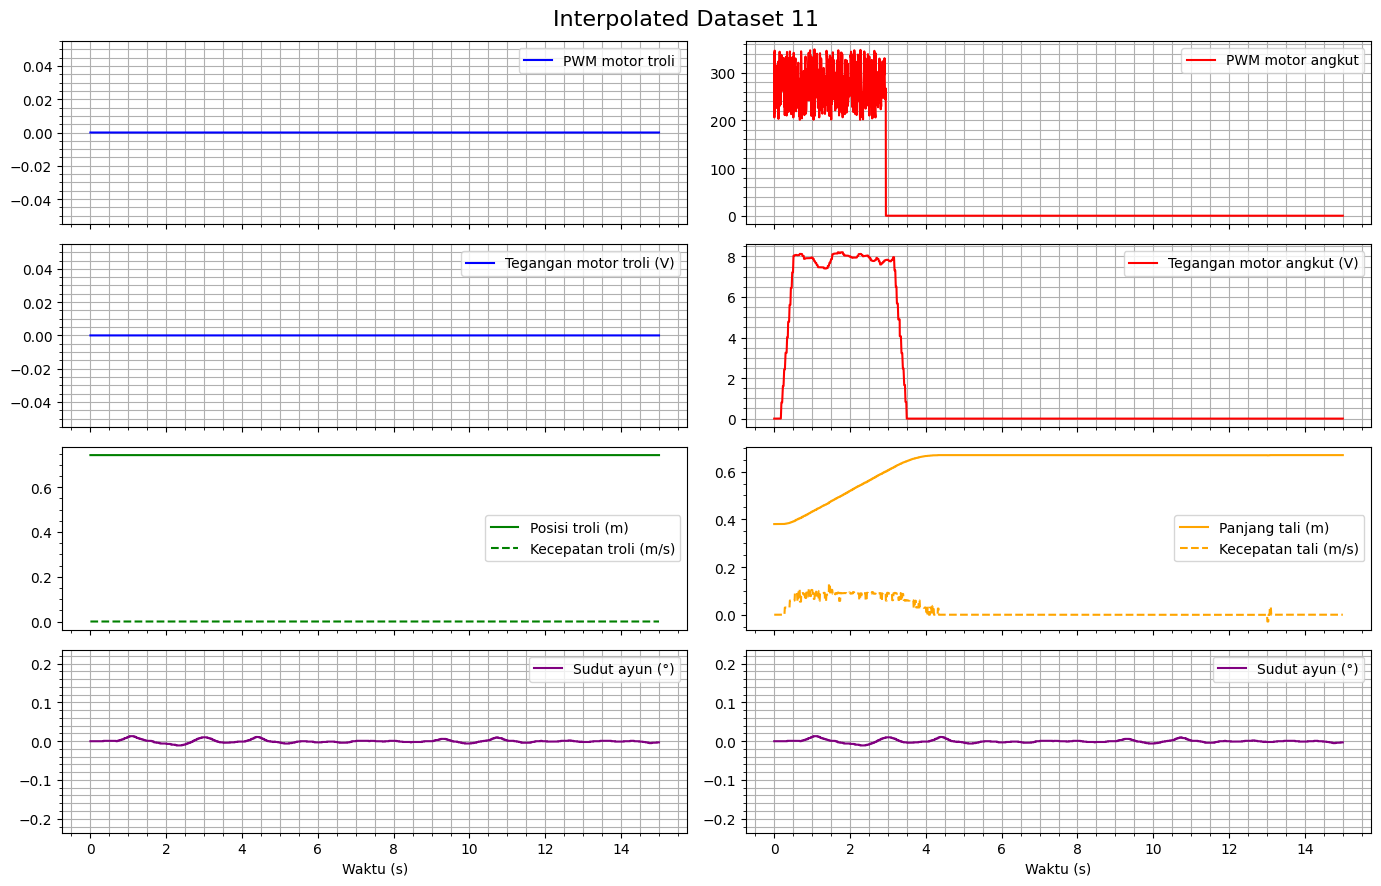

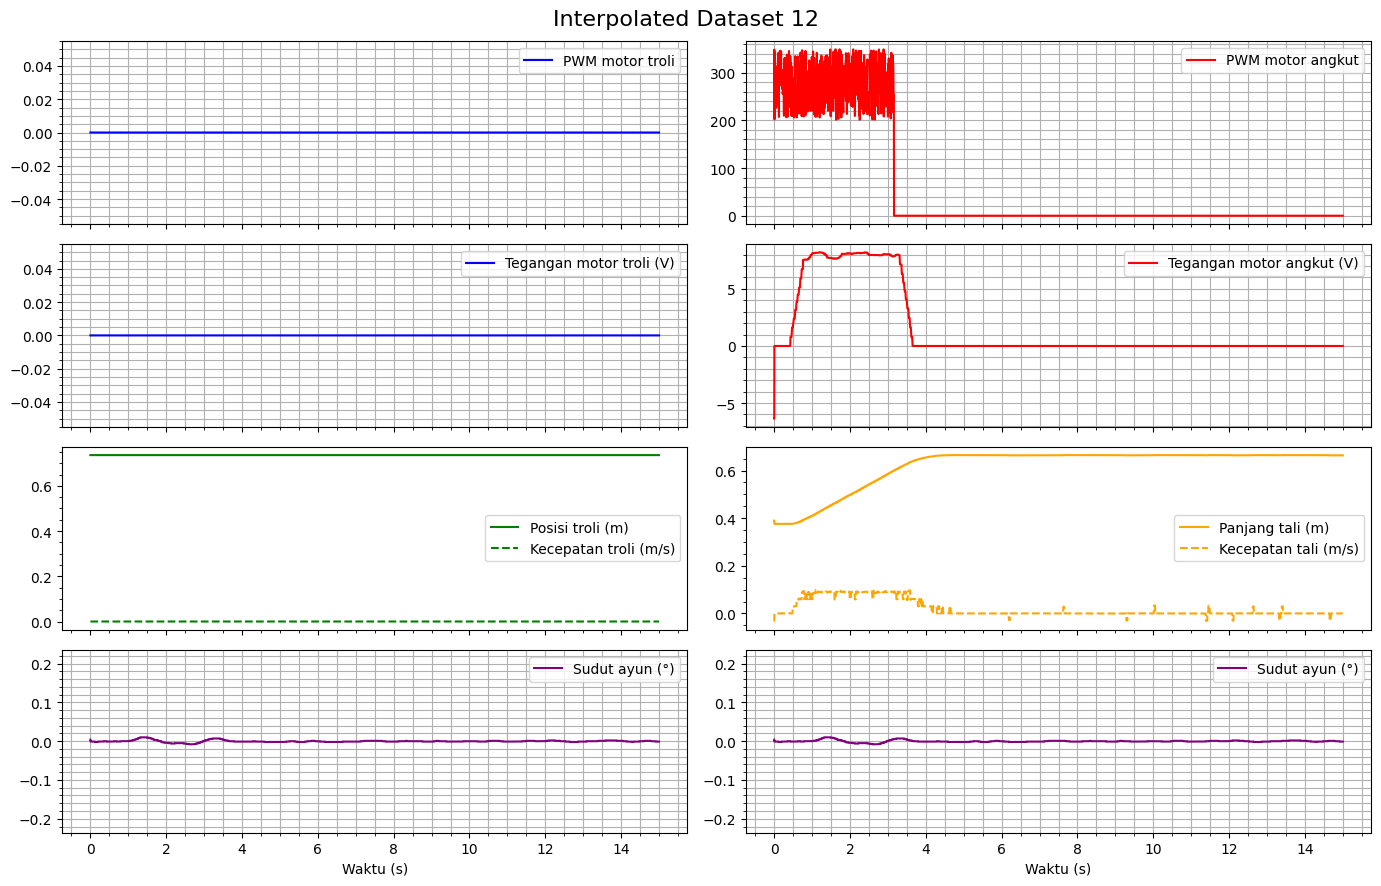

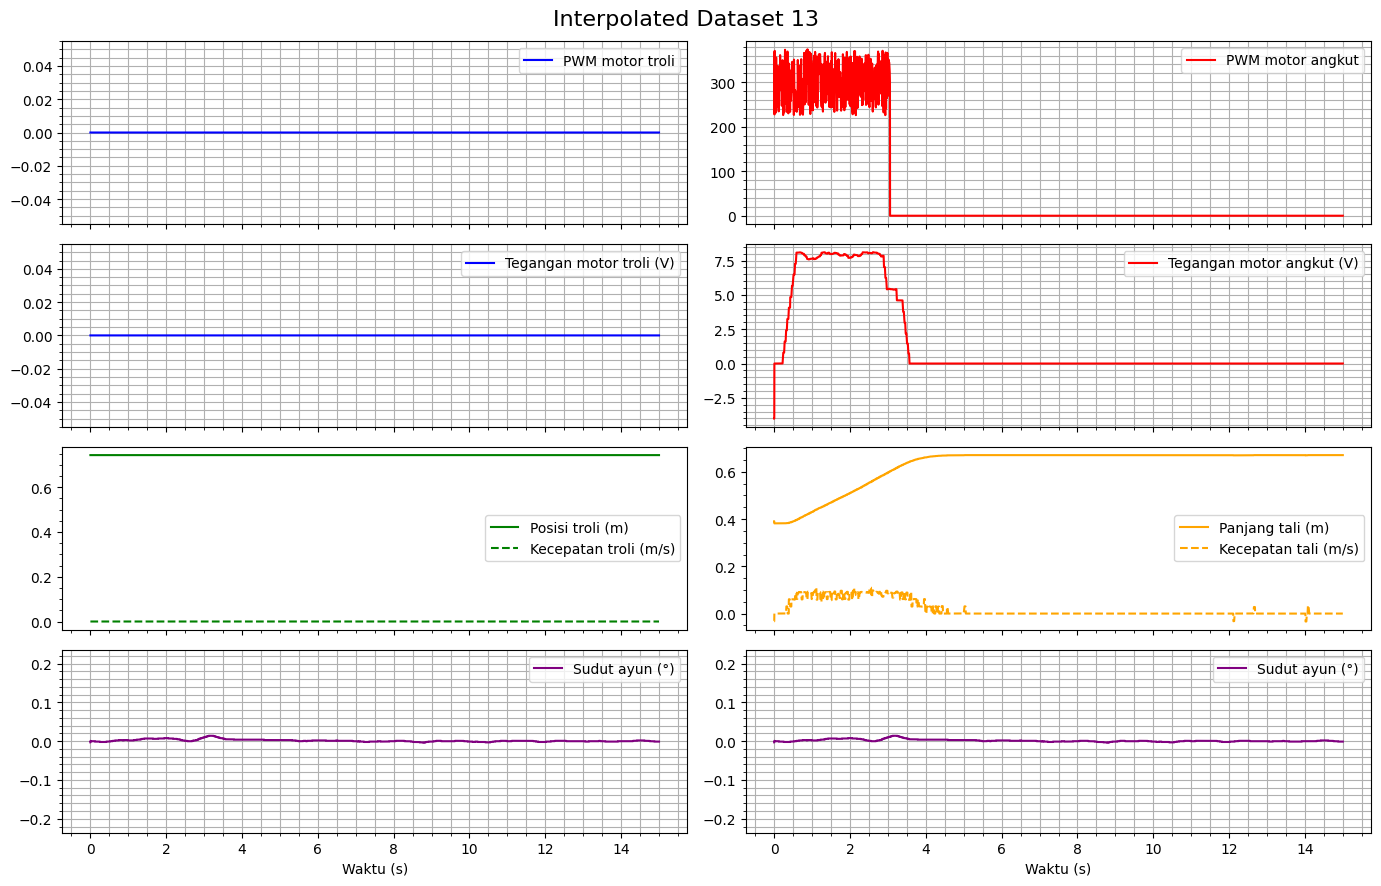

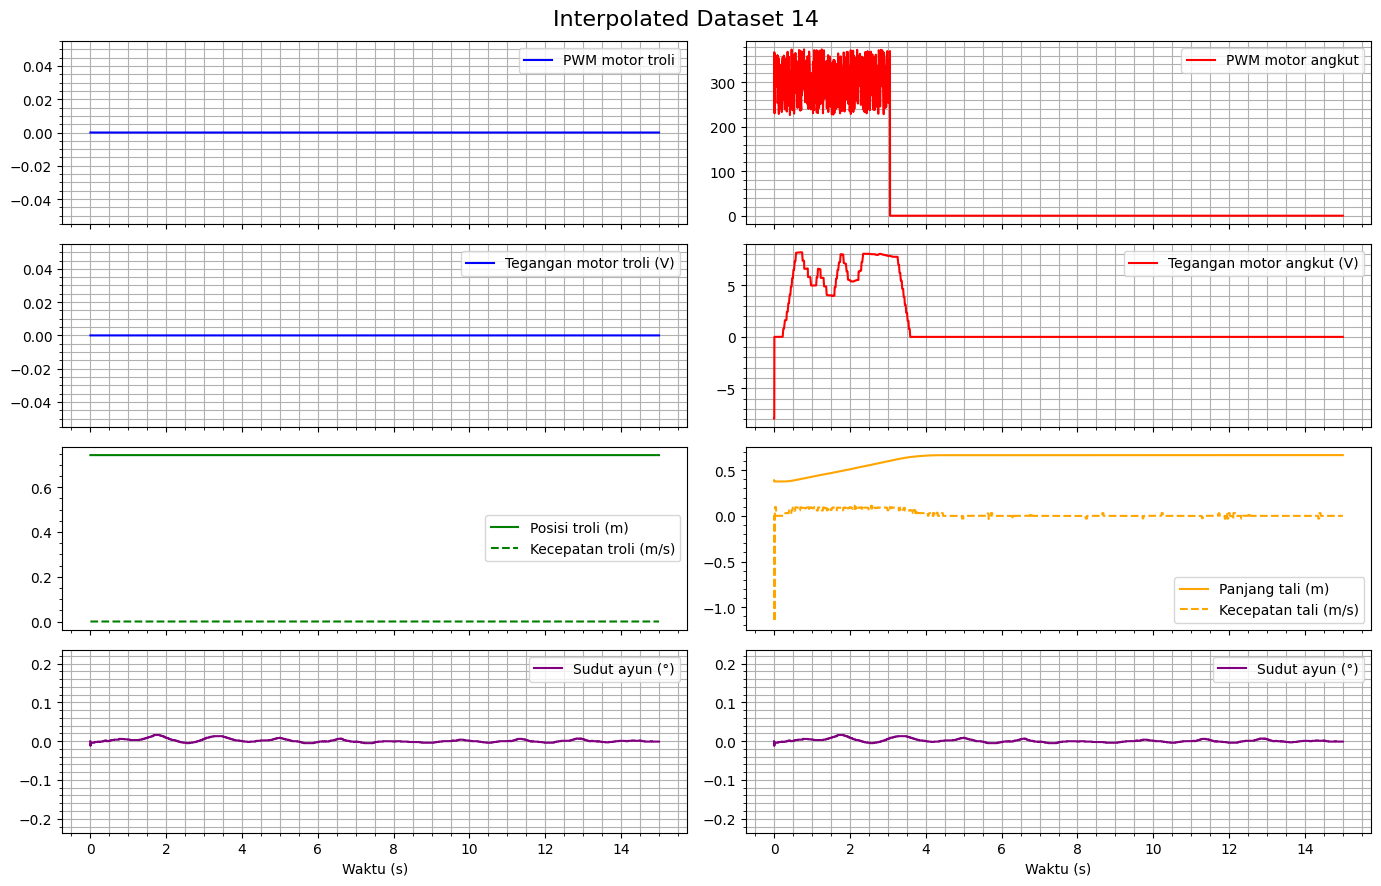

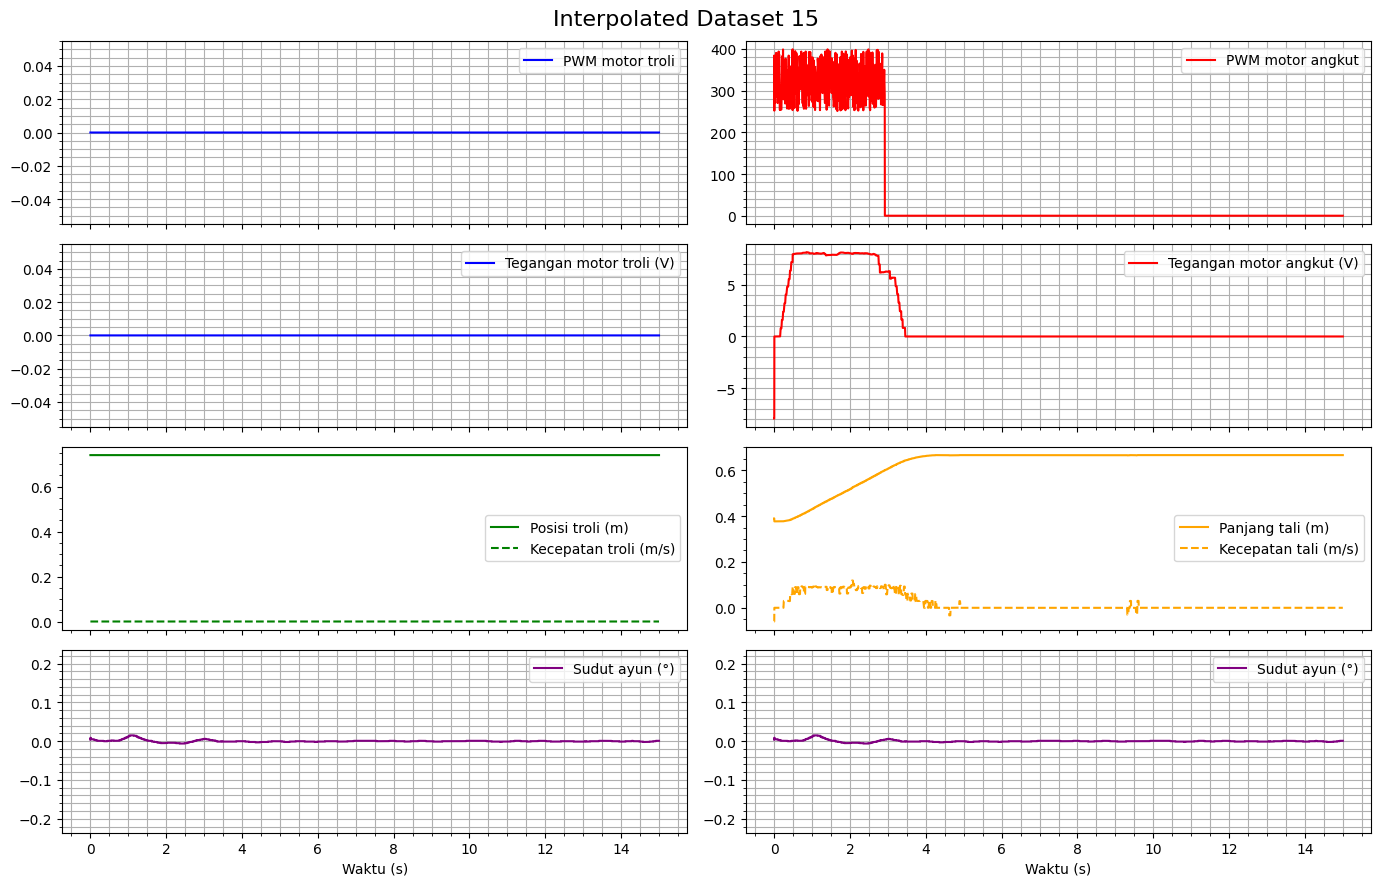

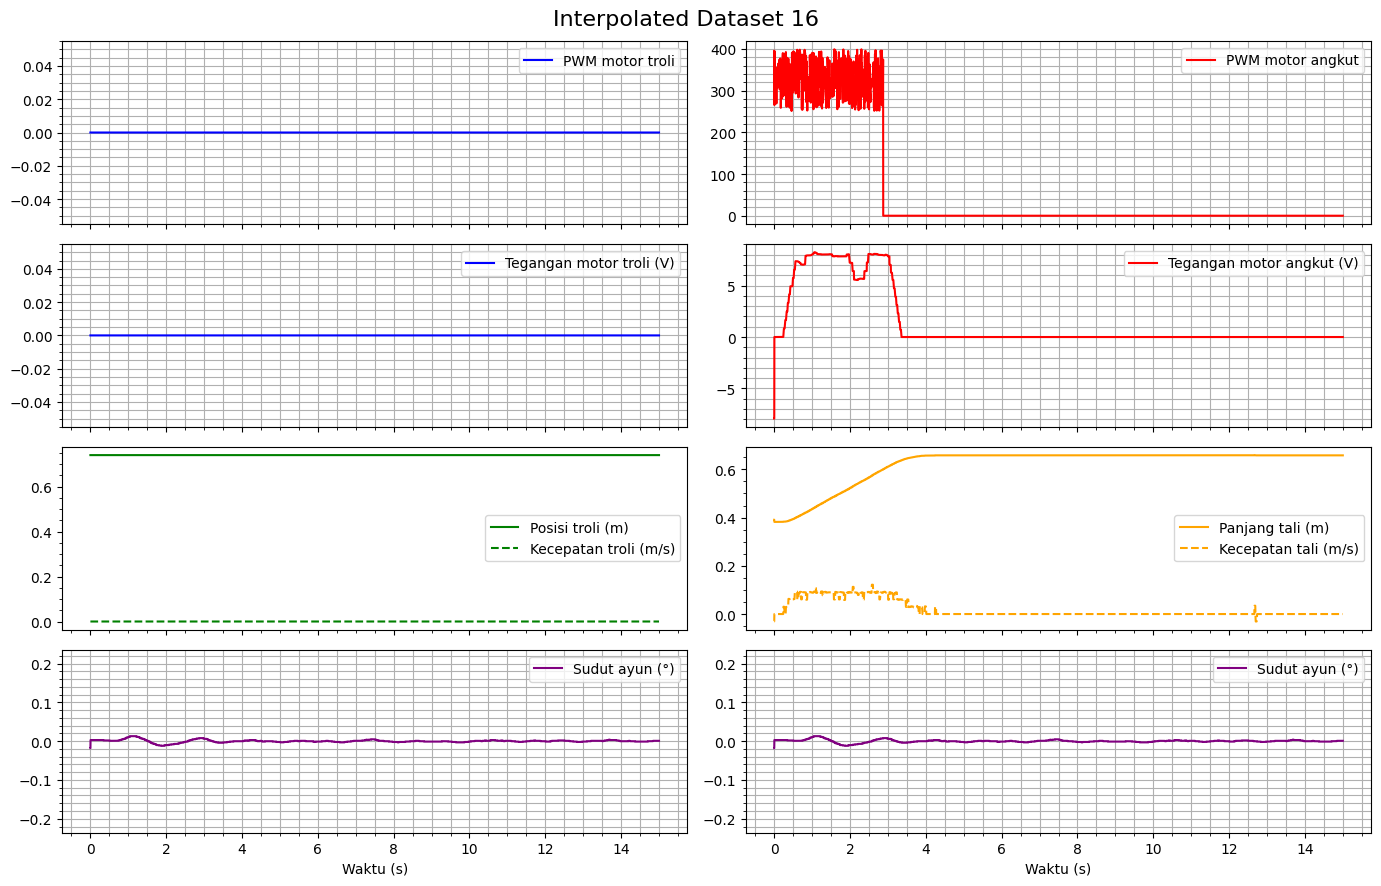

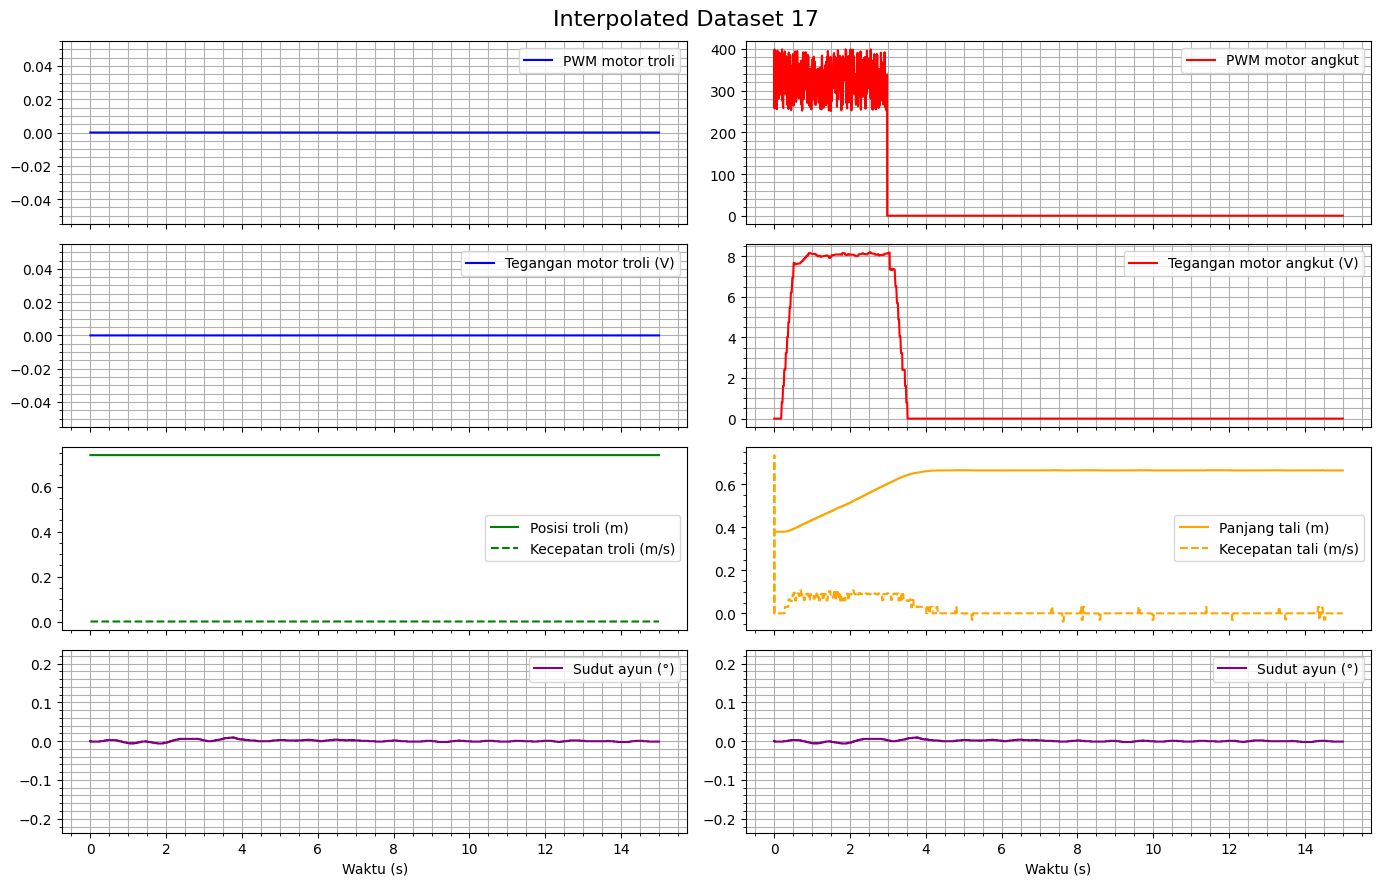

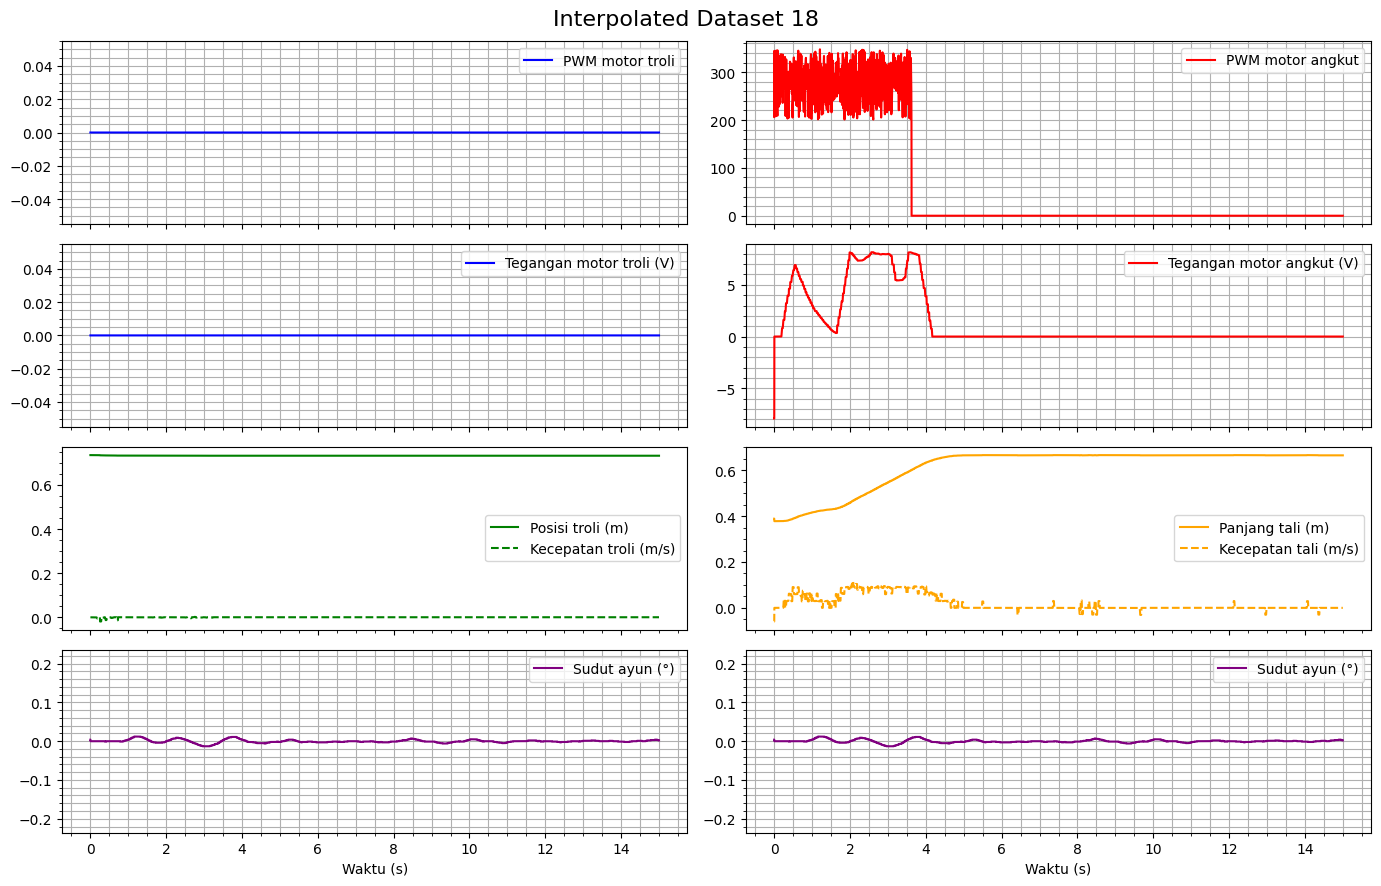

In [8]:
show_interpolated_datasets = True
if show_interpolated_datasets:
    for index, interpolated_dataset in enumerate(interpolated_datasets):
        # if (index >= 9 and index <= 20) or (index >= 30):
        #     continue
        # Create a figure and a set of subplots
        figure, ax = plt.subplots(4, 2, figsize=(14, 9), sharex=True)
        figure.suptitle(f"Interpolated Dataset {index+1}", fontsize=16)
        ut.add_to_subplot(ax[0, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_motor_pwm"], ylabel="PWM motor troli", color="blue")
        ut.add_to_subplot(ax[0, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["hoist_motor_pwm"], ylabel="PWM motor angkut", color="red")
        ut.add_to_subplot(ax[1, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_motor_voltage"], ylabel="Tegangan motor troli (V)", color="blue")
        ut.add_to_subplot(ax[1, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["hoist_motor_voltage"], ylabel="Tegangan motor angkut (V)", color="red")
        ut.add_to_subplot(ax[2, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_position"], ylabel="Posisi troli (m)", color="green")
        ut.add_to_subplot(ax[2, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["trolley_speed"], ylabel="Kecepatan troli (m/s)", color="green", linestyle="--")
        ut.add_to_subplot(ax[2, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["cable_length"], ylabel="Panjang tali (m)", color="orange")
        ut.add_to_subplot(ax[2, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["cable_speed"], ylabel="Kecepatan tali (m/s)", color="orange", linestyle="--")
        ut.add_to_subplot(ax[3, 0], interpolated_datasets[index]["time"], interpolated_datasets[index]["sway_angle"], "Waktu (s)", "Sudut ayun (°)", "purple")
        ut.add_to_subplot(ax[3, 1], interpolated_datasets[index]["time"], interpolated_datasets[index]["sway_angle"], "Waktu (s)", "Sudut ayun (°)", "purple")
        ax[3, 0].set_ylim(-max_sway_angle, max_sway_angle)
        ax[3, 1].set_ylim(-max_sway_angle, max_sway_angle)
        plt.tight_layout()
        plt.show()

In [10]:
# Open gantry crane parameter json file
USE_LAST_BEST_PARAMETERS = False
if USE_LAST_BEST_PARAMETERS:
    all_gantry_crane_parameters = ut.load_json(RESULTS_PATH + "best_parameters.json")
else:
    all_gantry_crane_parameters = ut.load_json(GANTRY_CRANE_PARAMETERS_JSON_PATH)["gantry_crane_system_model"]["parameters"]
print(all_gantry_crane_parameters)

{'trolley_damping_coefficient': {'value': 2.5, 'unit': 'Ns/m', 'description': 'Damping coefficient of the trolley', 'measured': False}, 'trolley_motor_damping_coefficient': {'value': 1.5, 'unit': 'Ns.m/rad', 'description': 'Damping coefficient of the trolley motor', 'measured': False}, 'trolley_motor_torque_constant': {'value': 0.5, 'unit': 'Nm/A', 'description': 'Torque constant of the trolley motor', 'measured': False}, 'trolley_motor_back_emf_constant': {'value': 0.00518, 'unit': 'V/(rad/s)', 'description': 'Back EMF constant of the trolley motor', 'measured': False}, 'trolley_motor_rotator_inertia': {'value': 0.0005859375, 'unit': 'kg.m^2', 'description': 'Rotational inertia of the trolley motor rotor', 'measured': False}, 'trolley_motor_activation_threshold_voltage': {'value': 4.0, 'unit': 'V', 'description': 'Activation threshold voltage of the trolley motor', 'measured': False}, 'cable_damping_coefficient': {'value': 5.0, 'unit': 'Ns/m', 'description': 'Damping coefficient of th

In [11]:
measured_parameters = {}
approximated_parameters = {}
for parameter in all_gantry_crane_parameters:
    if all_gantry_crane_parameters[parameter]["measured"]:
        measured_parameters[parameter] = all_gantry_crane_parameters[parameter]
    else:
        approximated_parameters[parameter] = all_gantry_crane_parameters[parameter]

# Print header of approximated parameters
print("Approximated Parameters")
print("Name", "Value")
for parameter in approximated_parameters:
    print(parameter, approximated_parameters[parameter]["value"])

Approximated Parameters
Name Value
trolley_damping_coefficient 2.5
trolley_motor_damping_coefficient 1.5
trolley_motor_torque_constant 0.5
trolley_motor_back_emf_constant 0.00518
trolley_motor_rotator_inertia 0.0005859375
trolley_motor_activation_threshold_voltage 4.0
cable_damping_coefficient 5.0
hoist_motor_damping_coefficient 2.5
hoist_motor_torque_constant 0.005
hoist_motor_back_emf_constant 0.25
hoist_motor_rotator_inertia 5.625e-05
hoist_motor_activation_threshold_voltage 4.0


In [12]:
for parameter in all_gantry_crane_parameters:
    # Continue if parameter have "trolley_*" or "hoist_*" in its name
    # if "trolley_" in parameter:
    #     continue
    if "hoist_" in parameter or "cable_" in parameter:
        continue
    if parameter in approximated_parameters:
        approximated_parameters.pop(parameter)

for parameter in approximated_parameters:
    print(parameter)

cable_damping_coefficient
hoist_motor_damping_coefficient
hoist_motor_torque_constant
hoist_motor_back_emf_constant
hoist_motor_rotator_inertia
hoist_motor_activation_threshold_voltage


In [13]:
from model import Simulator
simulator = Simulator(DT, NUM_STEPS)

In [14]:
def cost_function(parameter, datasets):
    average_sum_RMSE_squared = 0
    NUMBER_OF_DATASETS = len(datasets)
    for dataset in datasets:
        trolley_motor_input = dataset["trolley_motor_pwm"]
        hoist_motor_input = dataset["hoist_motor_pwm"]
        initial_conditions = {
            "x" : dataset["trolley_position"][0],
            "l" : dataset["cable_length"][0],
            "theta" : dataset["sway_angle"][0],
        }
        simulator.simulate(parameter, trolley_motor_input, hoist_motor_input, initial_conditions=initial_conditions)
        simulation_result = simulator.get_results()

        simulation_result_array = [simulation_result[key] for key in simulation_result]
        dataset_array = [dataset[key] for key in dataset]

        sum_RMSE = ut.calculate_sum_root_mean_squared_errors(simulation_result_array, dataset_array)
        if np.isnan(sum_RMSE):
            return np.inf
        
        average_sum_RMSE_squared += sum_RMSE**2
    
    average_sum_RMSE_squared /= NUMBER_OF_DATASETS
    
    return average_sum_RMSE_squared

In [15]:
optimize_range = {
    "trolley_mass": (0.001, 10.0),  # Done
    "trolley_damping_coefficient": (0.001, 10.0),  # Done
    "cable_damping_coefficient": (0.001, 10.0),  # Done
    "trolley_motor_rotator_inertia": (0.001, 10.0),  # Done
    "trolley_motor_damping_coefficient": (0.001, 100.0),
    "trolley_motor_back_emf_constant": (0.001, 10.0),  # Done
    "trolley_motor_torque_constant": (0.001, 10.0),  # Done
    "hoist_motor_rotator_inertia": (0.001, 10.0),  # Done
    "hoist_motor_damping_coefficient": (0.001, 10.0),
    "hoist_motor_back_emf_constant": (0.001, 10.0),  # Done
    "hoist_motor_torque_constant": (0.001, 100.0),  # Done
    "trolley_motor_activation_threshold_voltage": (0.001, 10.0),  # Done
    "hoist_motor_activation_threshold_voltage": (0.001, 10.0),  # Done
}

In [19]:
def initialize_population(n, dim, bounds):
    population = []
    for i in range(n):
        individual = np.random.uniform(bounds[0], bounds[1], dim)
        population.append(individual)
    return population

def levy_flight(beta, dim):
    sigma = (math.gamma(1 + beta) * np.sin(np.pi * beta / 2) / (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, dim)
    v = np.random.normal(0, 1, dim)
    step = u / np.abs(v) ** (1 / beta)
    return step

In [20]:
NUMBER_OF_DIMENSIONS = len(approximated_parameters)
NUMBER_OF_POPULATION = 10


[ 0.10063657  0.56157437 -0.88002834 -0.12895197 -4.827142   -0.27350875
 -3.67814704  0.3792324   2.13738746 -0.38515582]
